In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter

In [2]:
normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')
lon = np.array(ds.LON[jmin:jmax,imin:imax])
lat = np.array(ds.LAT[jmin:jmax,imin:imax])
H = np.array(ds.SH[jmin:jmax,imin:imax])
nlat,nlon = 91, 139

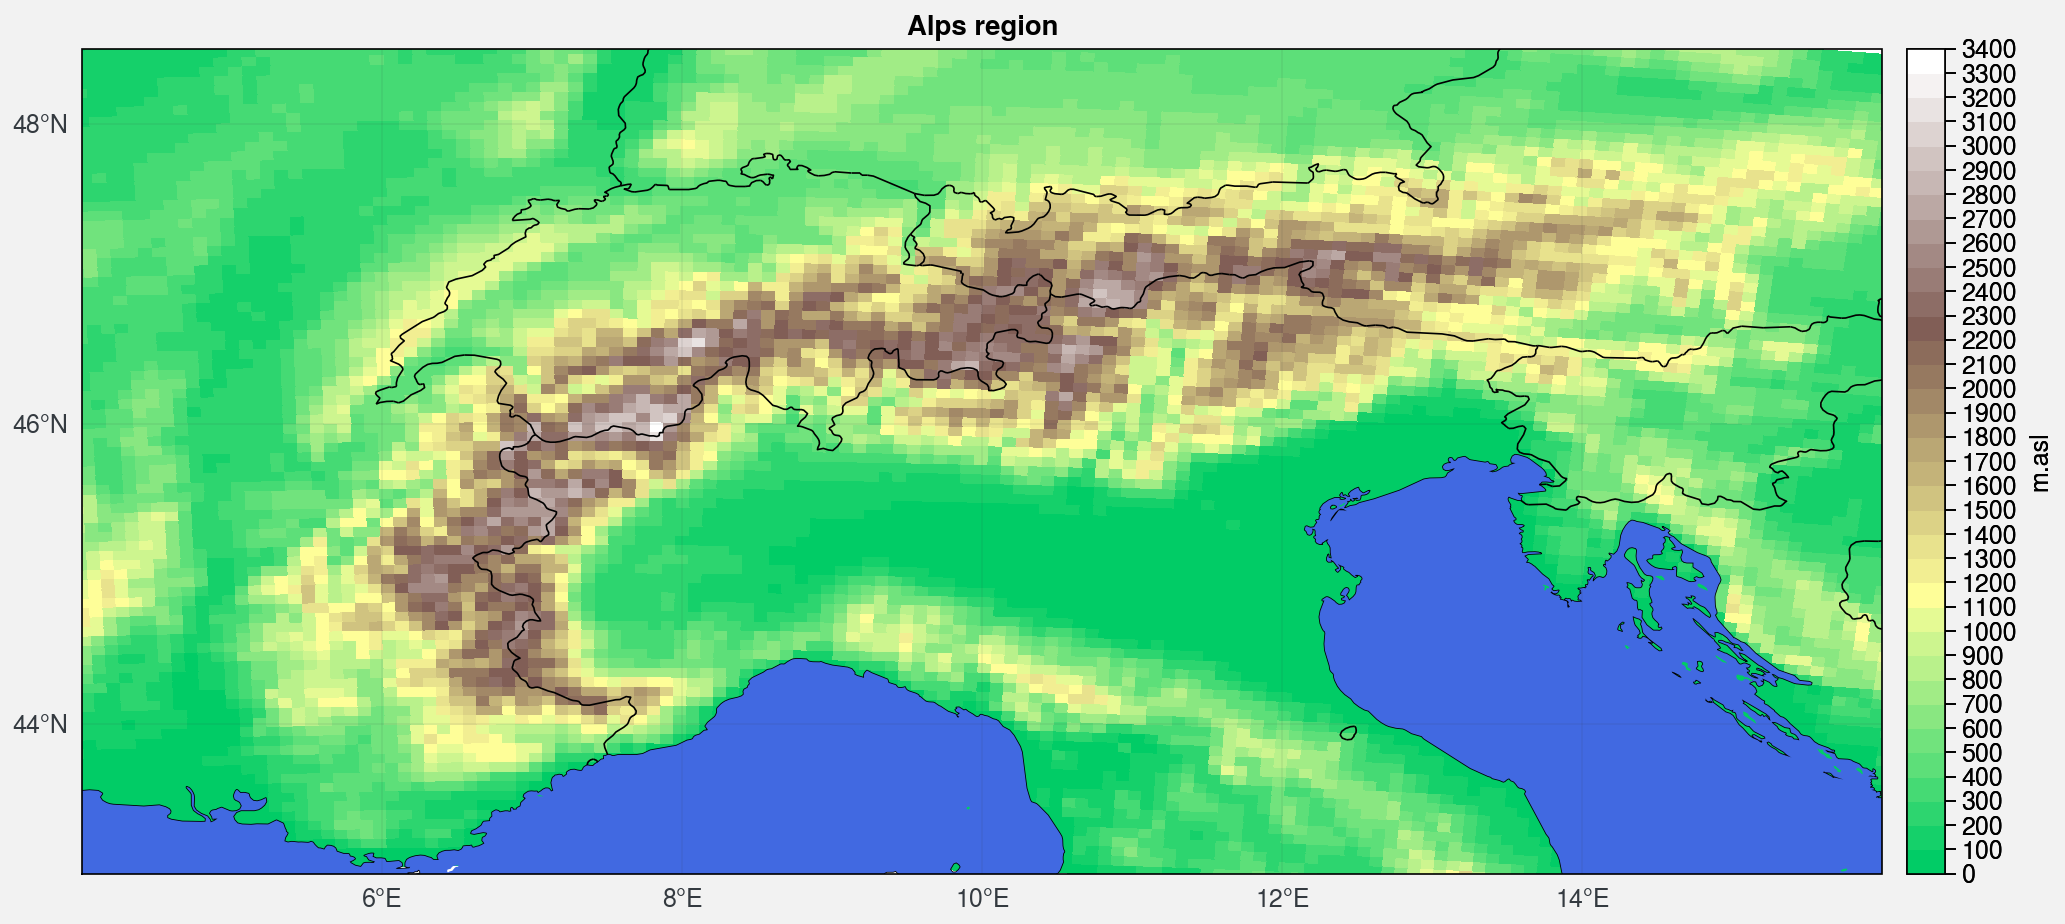

In [3]:
f, ax = pplt.subplots(proj='cyl', axwidth=9)
m=ax.pcolormesh(lon, lat, H, levels=34,cmap=colors_land)
f.colorbar(m,label= 'm.asl')

ax.format(**normal_format,suptitle='Alps region')
ax.format(ocean=True,oceancolor='royalblue',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])


In [4]:
# function for seasonal mean (from Nathan)
#def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(time)
#    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
#    weights = (
#        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
#    )

    # Test that the sum of the weights for each season is 1.0
#    np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
#    return (ds * weights).groupby("time.season").sum(dim="time")

# This method gives different weights to days from 28-, 30- and 31-day months, instead of giving an equal weight to each day in the season.

In [5]:
# function for seasonal mean (from Ian)
def season_mean(ds, calendar="standard"):
    #make a DataArray with the season of each day
    seas_array = ds.time.dt.season
    
    # count days in winter season (varies with leap years)
    nb_DJF = seas_array.str.count('DJF').sum()
    
    wgt_DJF = 1/nb_DJF.values.item()
    wgt_MAM = 1/(31+30+31)
    wgt_JJA = 1/(30+31+31)
    wgt_SON = 1/(30+31+30)

    weight = seas_array.str.replace('DJF',str(wgt_DJF)).str.replace('MAM',str(wgt_MAM)).str.replace('JJA',str(wgt_JJA)).str.replace('SON',str(wgt_SON))
    weight = weight.astype('float')
    
    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weight.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weight).groupby("time.season").sum(dim="time")

In [6]:
first_year = 1902
last_year = 1910
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    ds_T = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/daily/ICE.ERA-20C_v1.EUf.TTz.'+str(year)+'.nc')
    seasonal_mean_year=season_mean(ds_T.TTz.sel(ztqlev=2)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    if year> first_year:
        seasonal_mean += seasonal_mean_year
    else:
        seasonal_mean = xr.DataArray.copy(seasonal_mean_year)
seasonal_mean /= (last_year-first_year+1)

print(seasonal_mean.shape, seasonal_mean.season.data)

1902 1903 1904 1905 1906 1907 1908 1909 1910 (4, 126, 201) ['DJF' 'MAM' 'JJA' 'SON']
